# Cityscapes

This notebook is meant as an illustration how to reproduce those tables and figures from our paper that are based on the Cityscapes dataset.  
It also contains useful scripts to download and extract the used datasets and load our pretrained models and experimental configurations.  
To run the notebook for yourself, please follow the [installation instructions from the readme](https://github.com/ethz-asl/modular_semantic_segmentation/blob/publish/README.md).

### *Optional Config and Installation*

Simply jump over the steps you already did set up.

**1. Configuration**

In [ ]:
import xview
from os import path

# PLEASE EDIT THE FOLLOWING PATHS FOR YOUR LOCAL SETTINGS

# path where the image data will be/is stored
DATA_BASEPATH = '/tmp/test'

# path where experiment configs will be stored
EXPERIMENT_STORAGE_FOLDER = '/tmp/exp'

# only change in case you want to use tensorboard for model training, otherwise not relevant
EXP_OUT = '/tmp'

print('writing settings to %s' % path.join(path.dirname(xview.__file__), 'settings.py'))
with open(path.join(path.dirname(xview.__file__), 'settings.py'), 'w') as settings_file:
    settings_file.write("DATA_BASEPATH = '%s'\n" % DATA_BASEPATH)
    settings_file.write("EXPERIMENT_STORAGE_FOLDER = '%s'\n" % EXPERIMENT_STORAGE_FOLDER)
    settings_file.write("EXP_OUT = '%s'\n" % EXP_OUT)

**2. Downloading Cityscapes data**  
To download the cityscapes data, you have to [register](https://www.cityscapes-dataset.com/login/) with your own account. Please download the files `gtFine_trainvaltest.zip` and `leftImg8bit_trainvaltest.zip`. Afterwards, please place the downloaded archive in the following directory:

In [2]:
from xview.settings import DATA_BASEPATH; print(DATA_BASEPATH)

/tmp/test


Once placed in the above directory, the following code extracts and organizes the data.

In [4]:
from xview.settings import DATA_BASEPATH
from os import path, makedirs, remove
import zipfile
with zipfile.ZipFile(path.join(DATA_BASEPATH, 'gtFine_trainvaltest.zip')) as archive:
    archive.extractall(path.join(DATA_BASEPATH, 'cityscapes/gtFine_trainvaltest'))
with zipfile.ZipFile(path.join(DATA_BASEPATH, 'leftImg8bit_trainvaltest.zip')) as archive:
    archive.extractall(path.join(DATA_BASEPATH, 'cityscapes/leftImg8bit_trainvaltest'))
remove(path.join(DATA_BASEPATH, 'gtFine_trainvaltest.zip'))
remove(path.join(DATA_BASEPATH, 'leftImg8bit_trainvaltest.zip'))

**3. Downloading Experimental Data**  
All training and measurement experiments are bundeled into an archive that is downloaded and installed. This gives you access to pre-trained models and all experimental configurations.

In [ ]:
! wget http://robotics.ethz.ch/~asl-datasets/2018_modular_semantic_segmentation/experimental_data.tar.gz -O /tmp/experimental_data.tar.gz
import tarfile
from os import path
from xview.settings import EXPERIMENT_STORAGE_FOLDER
tar = tarfile.open('/tmp/experimental_data.tar.gz')
tar.extractall(path=EXPERIMENT_STORAGE_FOLDER)
tar.close()
! rm /tmp/experimental_data.tar.gz

# Single Examples for 'Cityscapes' Fusion
The following cells reproduce figure 4 from the paper.

The pretrained models for rgb (860) and depth (861) are loaded. Also, confusion matrices and dirichlet parameters fitted on the measure-set of Cityscapes are loaded from experiments 868 and 878.

In [4]:
from xview.datasets import Cityscapes
from xview.models import Adapnet, BayesFusion, AverageFusion, DirichletFusion
from experiments.utils import ExperimentData
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the relevant experiments. If this fails, your config from above is not setup properly.
rgb = ExperimentData(860)
depth = ExperimentData(861)
bayes = ExperimentData(868)
dirichlet = ExperimentData(878)

We now load example images to do inference of all the different fusion models. 39, 192 and 177 are the images also shown in the paper, you can test any other images by entering random indizes.

In [ ]:
data = Cityscapes(resize=True)
images = data._get_batch([data.testset[i] for i in [39, 192, 177]])

For inference, all configurations are loaded from the referenced experiments. Configurations include e.g. architecture details, which modalities of the data is used as input etc. As an example, this is the config for the bayes fusion:

In [7]:
bayes.get_record()['config']

{'evaluation_data': {'batchsize': 4,
  'dataset': 'cityscapes_c',
  'in_memory': True,
  'resize': True},
 'net_config': {'expert_model': 'adapnet',
  'learning_rate': 0,
  'num_channels': {'depth': 1, 'rgb': 3},
  'num_classes': 12,
  'num_units': 20,
  'prefixes': {'depth': 'depth', 'rgb': 'rgb'},
  'trainer': 'rmsprop'},
 'seed': 453280996,
 'starting_weights': {'depth': 861, 'rgb': 860}}

In [8]:
predictions = {}
# rgb and depth prediction
for key, exp in {'rgb': rgb, 'depth': depth}.items():
    config = exp.get_record()['config']['net_config']
    with Adapnet(data_description=data.get_data_description(), **config) as net:
        net.import_weights(exp.get_weights(), warnings=False)
        predictions[key] = net.predict(images)
# fusion predictions
config = bayes.get_record()['config']['net_config']
config['confusion_matrices'] = {m: np.array(val)
                                for m, val in bayes.get_record()['info']['confusion_matrices'].items()}

with BayesFusion(data_description=data.get_data_description(), **config) as net:
    [net.import_weights(exp.get_weights(), warnings=False) for exp in [rgb, depth]]
    predictions['bayes'] = net.predict(images)
    
with AverageFusion(data_description=data.get_data_description(), **config) as net:
    [net.import_weights(exp.get_weights(), warnings=False) for exp in [rgb, depth]]
    predictions['average'] = net.predict(images)
    
config = dirichlet.get_record()['config']['net_config']
config['dirichlet_params'] = {key: np.array(val)
                              for key, val in dirichlet.get_record()['info']['dirichlet_params'].items()}
with DirichletFusion(data_description=data.get_data_description(), **config) as net:
    [net.import_weights(exp.get_weights(), warnings=False) for exp in [rgb, depth]]
    predictions['dirichlet'] = net.predict(images)

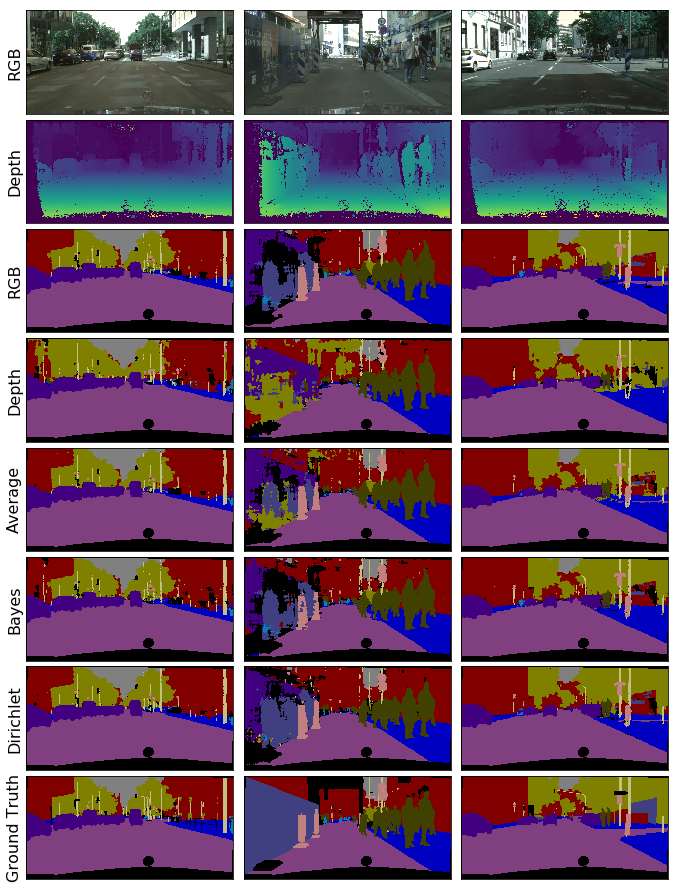

In [9]:
ncols = images['rgb'].shape[0]
label_params = {'fontsize': 16}
fig, axs = plt.subplots(8, ncols, figsize=(11.5,16), gridspec_kw = {'wspace':.05, 'hspace':.05})

for col in range(ncols):
    axs[0][col].imshow(images['rgb'][col].astype('int'))
    axs[1][col].imshow(np.squeeze(images['depth'][col]))
    axs[2][col].imshow(data.coloured_labels(predictions['rgb'][col]))
    axs[3][col].imshow(data.coloured_labels(predictions['depth'][col]))
    axs[4][col].imshow(data.coloured_labels(predictions['average'][col]))
    axs[5][col].imshow(data.coloured_labels(predictions['bayes'][col]))
    axs[6][col].imshow(data.coloured_labels(predictions['dirichlet'][col]))
    axs[7][col].imshow(data.coloured_labels(images['labels'][col]))

for row, title in {0: 'RGB', 1: 'Depth', 2: 'RGB', 3: 'Depth', 4: 'Average', 5: 'Bayes',
                   6: 'Dirichlet', 7: 'Ground Truth'}.items():
    axs[row][0].set_ylabel(title, **label_params)
    for ax in axs[row]:
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

# Quantitative Evaluation of 'Synthia RAND' Fusion

In the following, we compare the different fusion methods quantitatively and show how the tables in the paper were produced.  
The function `print_tables` simply loads the measurements out of the referenced experiments and displays all results in a table. In particular, these cells do not measure the model's against the Cityscapes test set, but load measurement results that were produced by the authors.  
Below the tables we show how to revalidate the measurement results.

In [15]:
def print_tables(data, **experiments):
    table_data = {}
    for key, experiment_id in experiments.items():
        measurements = ExperimentData(experiment_id).get_record()['info']['measurements']
        if key == 'bayes':
            table_data[key.title()] = measurements['fusion']['IoU']
            # with the bayes experiments, we also measure the single baselines
            for modality in ('RGB', 'Depth'):
                table_data[modality] = measurements[modality.lower()]['IoU']
        else:
            table_data[key.title()] = measurements['IoU']
        
    classes = pd.DataFrame(table_data, index=[i['name'] for i in data.labelinfo.values()])
    mean = pd.DataFrame({col: classes[col][1:].mean() for col in classes.columns}, index=['mean'])
    
    # now order the columns
    ordered_columns = []
    for key in ['Fusion_Fcn', 'Dirichlet', 'Bayes', 'Average', 'Variance', 'RGB', 'Depth']:
        if key in classes.columns:
            ordered_columns.append(key)
    return mean.append(classes)[ordered_columns]
pd.set_option('display.precision', 4)

**1. Both RGB and Depth trained on Cityscapes** (Table III)

In [16]:
print_tables(Cityscapes(), bayes=868, average=867, dirichlet=878)

,Dirichlet,Bayes,Average,RGB,Depth
mean,0.6922,0.6877,0.6847,0.6920,0.5412
void,0.6520,0.6498,0.6814,0.6575,0.6577
sky,0.8697,0.9045,0.8893,0.9054,0.7860
building,0.8460,0.8359,0.8432,0.8409,0.7283
road,0.9237,0.9171,0.9259,0.9153,0.9179
sidewalk,0.6766,0.6501,0.6725,0.6642,0.5758
fence,0.4154,0.3792,0.4079,0.3984,0.2362
vegetation,0.8713,0.8804,0.8448,0.8804,0.6656
pole,0.4423,0.4211,0.4377,0.4194,0.3328
vehicle,0.8762,0.8620,0.8702,0.8654,0.7792


**2. With Depth trained on Synthia RAND** (Table IV)

In [10]:
print_tables(SynthiaCityscapes(labels={'lanemarkings': True}), bayes=820, average=819, dirichlet=856)

,Dirichlet,Bayes,Average,RGB,Depth
mean,0.801852,0.799118,0.790490,0.759173,0.637632
void,0.798663,0.753131,0.798512,0.738616,0.719206
sky,0.973943,0.974090,0.955738,0.955436,0.094735
building,0.968455,0.967552,0.961995,0.936966,0.798560
road,0.940887,0.927821,0.931128,0.915791,0.889205
sidewalk,0.950653,0.940441,0.946958,0.917111,0.935961
fence,0.747647,0.729677,0.745399,0.683018,0.718872
vegetation,0.898939,0.906167,0.900205,0.814190,0.903152
pole,0.655285,0.664174,0.647926,0.561722,0.601941
car,0.931914,0.913920,0.928124,0.878054,0.905565


## How to reproduce quantitative measurements
To reproduce the evaluation experiments listed above, simply run the following cell with the correct `experiment_id`. The command will run the exact same script that was used to produce the measurement results. It will load the pretrained models, measure them on the measurement-set and use the measurements to produce decision functions for the bayes fusion or dirichlet fusion. Again, all the configurations of an experiment_id can be accessed with `ExperimentData(<experiment_id>).get_record()['config']`.  
More info on the experiment management can be found [here](http://sacred.readthedocs.io/en/latest/).

**There seem to be implementational issues internal to tensorflow. We experienced different results on CPU and GPU. The below example is run on a CPU, the reported results were computed (and validated multiple times) on a GPU. Please note the difference of 2% IoU.**

In [22]:
! python -m experiments.rerun with experiment_id=868 -u

WARNING - root - Added new config entry: "experiment_id"
INFO - rerun - Running command 'rerun'
INFO - rerun - Started
Re-Run of experiment "cityC bayes fusion"
2018-07-23 11:27:20.116544: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-07-23 11:27:20.590292: W tensorflow/core/framework/allocator.cc:108] Allocation of 16777216 exceeds 10% of system memory.
2018-07-23 11:27:20.596442: W tensorflow/core/framework/allocator.cc:108] Allocation of 16777216 exceeds 10% of system memory.
2018-07-23 11:27:20.684443: W tensorflow/core/framework/allocator.cc:108] Allocation of 16777216 exceeds 10% of system memory.
2018-07-23 11:27:20.690833: W tensorflow/core/framework/allocator.cc:108] Allocation of 16777216 exceeds 10% of system memory.
2018-07-23 11:27:20.802845: W tensorflow/core/framework/allocator.cc:108] Allocation of 16777216 exceeds 10% of system memory.
INFO Environment Variable TMPD

/home/spadmin/Dropbox/ETH/Masterarbeit/documentation/iros_paper/newdata/861/Adapnet_weights_100000.npz


Evaluated Bayes Fusion on cityscapes_c data:
total accuracy 0.907 IoU 0.666
INFO - rerun - Completed after 1:00:11
